In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn

import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.seasonal import seasonal_decompose, STL

# loading dataset

In [2]:
df = pd.read_csv('../input/aeroplane-crash-data-from-1919-to-2025/cleaned_data.csv')

In [3]:
df.head()

,aircraft_type,registration,operator,fatalities,location,damage,Time,Flight #,Route,cn/In,...,crashes,serious_injuries,minor_injuries,incidents,date,year,month,day,hour,fatality_overcount
0,wright flyer iii,unknown,military - u.s. army,1.0,"fort myer, virginia",unknown,17:18,unknown,demonstration,1,...,0.0,0.0,0.0,0.0,1908-09-17,1908,9,17,17,False
1,dirigible,unknown,mililtary - u.s. navy,5.0,"atlanticity, new jersey",unknown,06:30,unknown,test flight,unknown,...,0.0,0.0,0.0,0.0,1912-07-12,1912,7,12,6,False
2,curtiss seaplane,unknown,private,1.0,"victoria, british columbia, canada",unknown,Unknown,-,unknown,unknown,...,0.0,0.0,0.0,0.0,1913-08-06,1913,8,6,-1,False
3,zeppelin l-1 (airship),unknown,military - german navy,14.0,over the north sea,unknown,18:30,unknown,unknown,unknown,...,0.0,0.0,0.0,0.0,1913-09-09,1913,9,9,18,False
4,zeppelin l-2 (airship),unknown,military - german navy,30.0,"near johannisthal, germany",unknown,10:30,unknown,unknown,unknown,...,0.0,0.0,0.0,0.0,1913-10-17,1913,10,17,10,False


In [4]:
df.isnull().sum()

aircraft_type         0
registration          0
operator              0
fatalities            0
location              0
damage                0
Time                  0
Flight #              0
Route                 0
cn/In                 0
Aboard                0
Ground                0
Summary               0
summary               0
crashes               0
serious_injuries      0
minor_injuries        0
incidents             0
date                  0
year                  0
month                 0
day                   0
hour                  0
fatality_overcount    0
dtype: int64

In [5]:
df.fatality_overcount.value_counts()

fatality_overcount
False    22055
True      8913
Name: count, dtype: int64

# data preprocessing

In [6]:
# renaming columns
df.rename(columns={'Summary': 'summ1', 'summary': 'summ2'}, inplace=True)
df.rename(columns={'Flight #': 'flight_num'}, inplace=True)

In [7]:
# converting columns to lowercase
df.columns = df.columns.str.lower()

In [8]:
# converting data type from float to int
df.aboard = df.aboard.astype(int)
df.fatalities = df.fatalities.astype(int)
df.crashes = df.crashes.astype(int)
df.serious_injuries = df.serious_injuries.astype(int)
df.minor_injuries = df.minor_injuries.astype(int)
df.incidents = df.incidents.astype(int)

In [9]:
df.shape

(30968, 24)

In [10]:
# taking last 1 decade data
df = df[(df['year'] >= 2015) & (df['year'] <= 2025)]

In [11]:
df.shape

(2521, 24)

In [12]:
# reset index to date (datetime)
df['ts'] = pd.to_datetime(df[['year','month','day','hour']])
df = df.set_index('ts').sort_index()

In [13]:
# reset index to date (datetime)
# df['date'] = pd.to_datetime(df['date'])
# df.set_index('ts', inplace = True)
df.head(2)

,aircraft_type,registration,operator,fatalities,location,damage,time,flight_num,route,cn/in,...,crashes,serious_injuries,minor_injuries,incidents,date,year,month,day,hour,fatality_overcount
ts,,,,,,,,,,,,,,,,,,,,,
2014-12-31 23:00:00,unknown,unknown,unknown,898,unknown,unknown,Unknown,unknown,unknown,unknown,...,0,0,0,123,2015-01-01,2015,1,1,-1,True
2014-12-31 23:00:00,unknown,unknown,unknown,1112,unknown,unknown,Unknown,unknown,unknown,unknown,...,1600,364,473,0,2015-01-01,2015,1,1,-1,True


In [14]:
# print(df[df.summ1 == 'No summary available'].value_counts().sum()) # 240 valid

# print(df[df.summ2 == 'No summary available'].value_counts().sum()) # 6 valid

# print(df[(df.summ2 == 'No summary available') & (df.summ1 == 'No summary available')].value_counts().sum()) # 246

In [15]:
df.columns

Index(['aircraft_type', 'registration', 'operator', 'fatalities', 'location',
       'damage', 'time', 'flight_num', 'route', 'cn/in', 'aboard', 'ground',
       'summ1', 'summ2', 'crashes', 'serious_injuries', 'minor_injuries',
       'incidents', 'date', 'year', 'month', 'day', 'hour',
       'fatality_overcount'],
      dtype='object')

# segmentation

In [16]:
new_df = df[['aircraft_type','operator','location','aboard','ground',
       'summ1', 'summ2', 'crashes','incidents','fatalities','serious_injuries', 'minor_injuries']]

new_df.ground = new_df.ground.astype(int)
new_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2521 entries, 2014-12-31 23:00:00 to 2025-11-13 23:00:00
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   aircraft_type     2521 non-null   object
 1   operator          2521 non-null   object
 2   location          2521 non-null   object
 3   aboard            2521 non-null   int64 
 4   ground            2521 non-null   int64 
 5   summ1             2521 non-null   object
 6   summ2             2521 non-null   object
 7   crashes           2521 non-null   int64 
 8   incidents         2521 non-null   int64 
 9   fatalities        2521 non-null   int64 
 10  serious_injuries  2521 non-null   int64 
 11  minor_injuries    2521 non-null   int64 
dtypes: int64(7), object(5)
memory usage: 256.0+ KB


In [17]:
# new_df['aircraft_type'].value_counts().head(50) 
# new_df['operator'].value_counts().head(50)

In [18]:
new_df['dow']  = new_df.index.dayofweek
new_df['week'] = new_df.index.isocalendar().week.astype(int)

In [19]:
# new_df[new_df['aircraft_type']=='unknown'].value_counts().sum() # 16
# new_df[new_df['operator']=='unknown'].value_counts().sum() # 64

In [20]:
# dropping unknown aircraft_type and summary col
new_df = new_df[~new_df['aircraft_type'].str.contains('unknown', case=False, na=False)]
new_df.drop(['summ1','summ2'], axis=1, inplace=True)

# top_ops
new_df['operator'] = new_df['operator'].replace({'unknown': 'Unknown_Operator'})
top_ops = new_df['operator'].value_counts().head(50).index
new_df['operator'] = np.where(new_df['operator'].isin(top_ops), new_df['operator'], 'Other')

In [21]:
new_df.head()

,aircraft_type,operator,location,aboard,ground,crashes,incidents,fatalities,serious_injuries,minor_injuries,dow,week
ts,,,,,,,,,,,,
2015-01-01 23:00:00,saab 340b,Other,stornoway airport (syy),0,0,0,0,0,0,0,3,1
2015-01-02 23:00:00,antonov an-26b-100,Other,magadan-sokol airport (gdx),0,0,0,0,0,0,0,4,1
2015-01-03 23:00:00,fokker 50,Other,nairobi-jomo kenyatta international airport (nbo),0,0,0,0,0,0,0,5,1
2015-01-07 23:00:00,bombardier bd-100-1a10 challenger 300,Other,"são paulo-congonhas airport, sp (cgh/sbsp)",0,0,0,0,0,0,0,2,2
2015-01-08 23:00:00,cessna 208b grand caravan,Other,matthews ridge airport (mwj),0,0,0,0,0,0,0,3,2


In [22]:
[{x:new_df[x].nunique()} for x in new_df.columns]

[{'aircraft_type': 833},
 {'operator': 51},
 {'location': 2031},
 {'aboard': 1},
 {'ground': 1},
 {'crashes': 1},
 {'incidents': 1},
 {'fatalities': 50},
 {'serious_injuries': 1},
 {'minor_injuries': 1},
 {'dow': 7},
 {'week': 53}]

In [23]:
new_df[['crashes','incidents','fatalities','aboard','serious_injuries','minor_injuries']].ne(0).sum()


crashes               0
incidents             0
fatalities          398
aboard                0
serious_injuries      0
minor_injuries        0
dtype: int64

# plotting and visualization

## crash counts by year, month, day

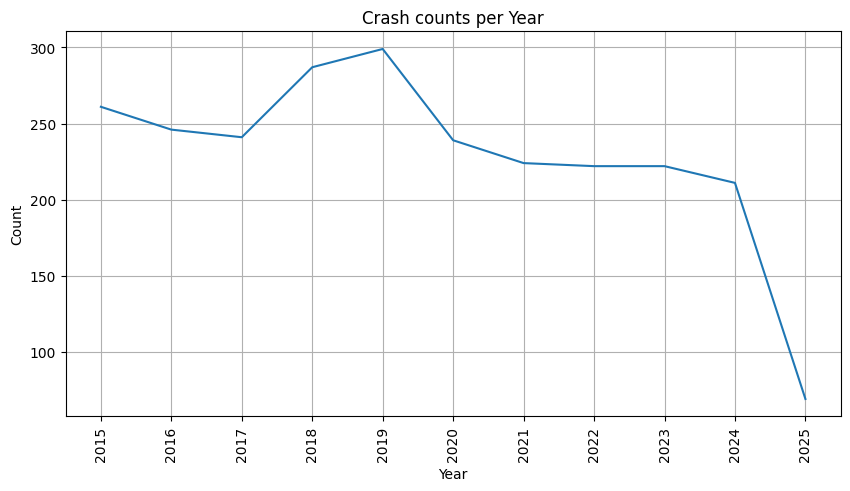

In [24]:
# no. of crashes happended per year
plt.figure(figsize=(10,5))
df['year'].value_counts().sort_index().plot(rot=90, kind='line').set_xticks(df['year'].value_counts().sort_index().index)
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Crash counts per Year')
plt.grid(True)
plt.show()

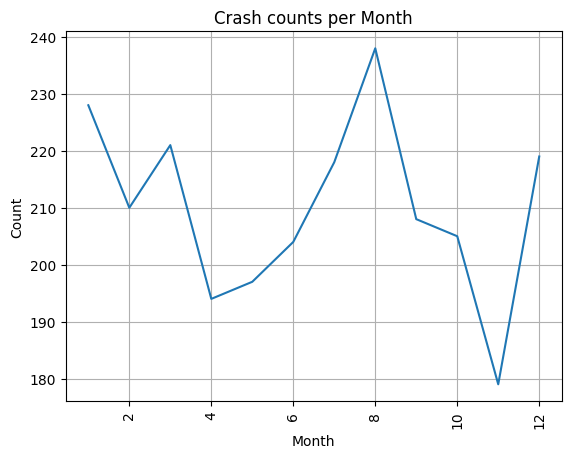

In [25]:
# no. of crashes happended per month
df['month'].value_counts().sort_index().plot(rot=90, kind='line') 
plt.xlabel('Month')
plt.ylabel('Count')
plt.title('Crash counts per Month')
plt.grid(True)
plt.show()

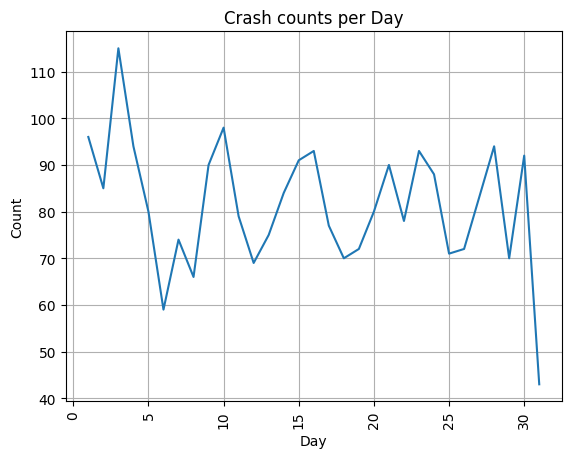

In [26]:
# no. of crashes happended per day
df['day'].value_counts().sort_index().plot(rot=90, kind='line') 
plt.xlabel('Day')
plt.ylabel('Count')
plt.title('Crash counts per Day')
plt.grid(True)
plt.show()

## incidents counts by year, month, day

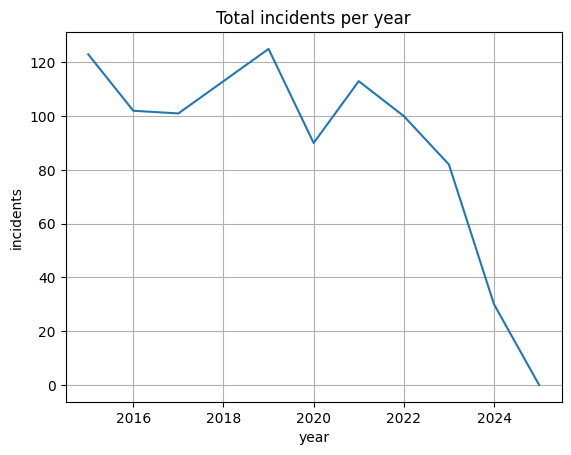

In [27]:
# total incidents by year
ax = sn.lineplot(data=df.groupby('year')[['incidents']].sum().reset_index(), x='year', y='incidents')
ax.set_xticklabels([int(tick) for tick in ax.get_xticks()])
plt.title('Total incidents per year')
plt.grid(True)
plt.show()

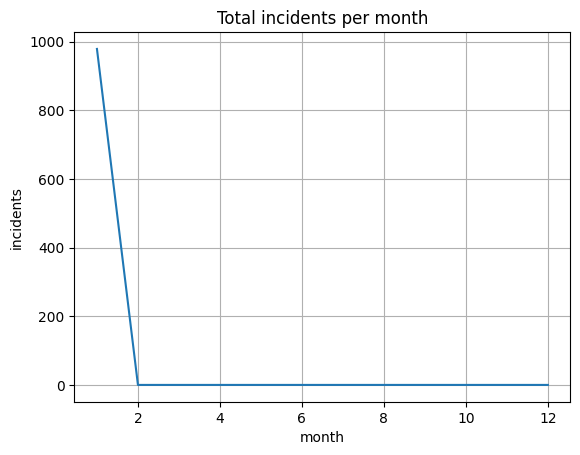

In [28]:
# total incidents by month
ax = sn.lineplot(data=df.groupby('month')[['incidents']].sum().reset_index(), x='month', y='incidents')
plt.title('Total incidents per month')
plt.grid(True)
plt.show()

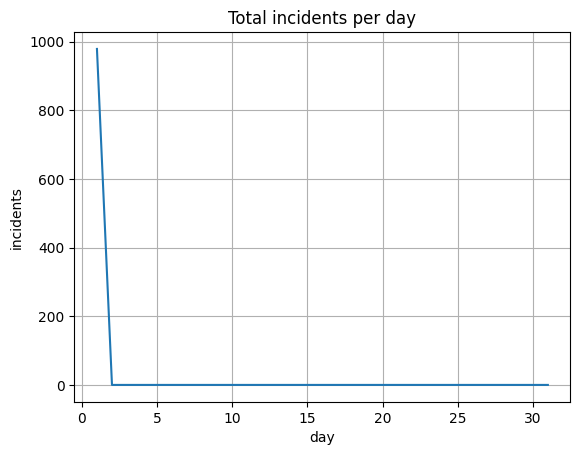

In [29]:
# total incidents by day
ax = sn.lineplot(data=df.groupby('day')[['incidents']].sum().reset_index(), x='day', y='incidents')
plt.title('Total incidents per day')
plt.grid(True)
plt.show()

## fatalities counts by year, month, day

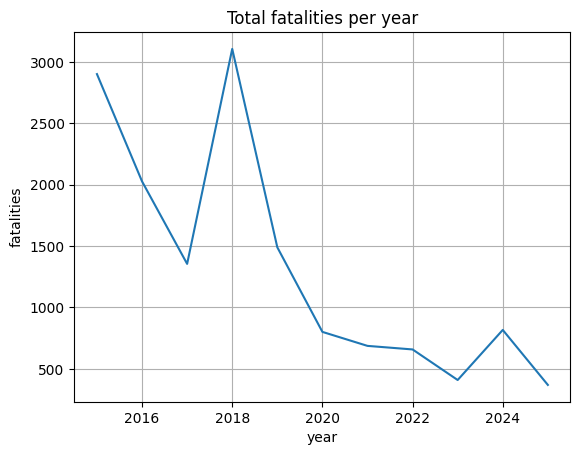

In [30]:
# total incidents by year
ax = sn.lineplot(data=df.groupby('year')[['fatalities']].sum().reset_index(), x='year', y='fatalities')
ax.set_xticklabels([int(tick) for tick in ax.get_xticks()])
plt.title('Total fatalities per year')
plt.grid(True)
plt.show()

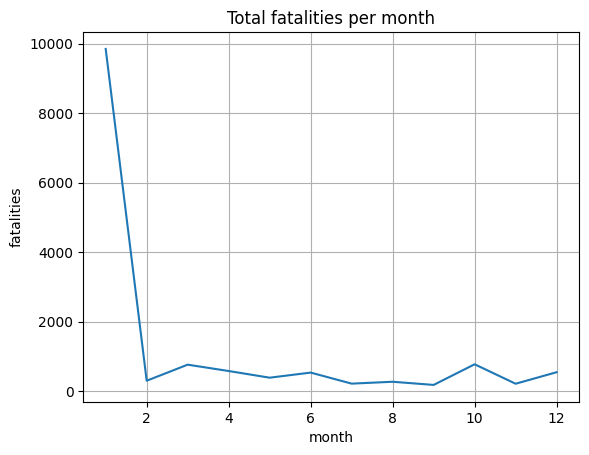

In [31]:
# total fatalities by month
ax = sn.lineplot(data=df.groupby('month')[['fatalities']].sum().reset_index(), x='month', y='fatalities')
plt.title('Total fatalities per month')
plt.grid(True)
plt.show()

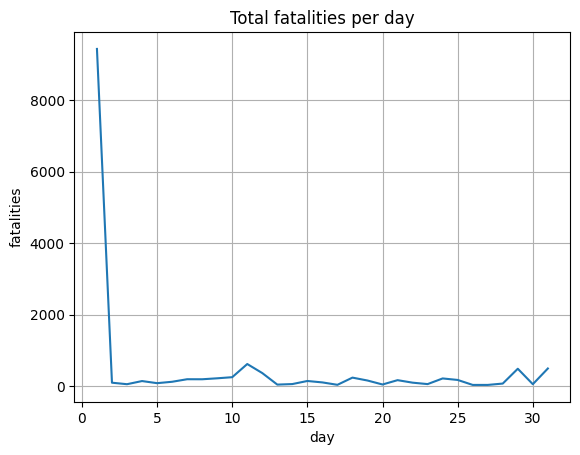

In [32]:
# total fatalities by day
ax = sn.lineplot(data=df.groupby('day')[['fatalities']].sum().reset_index(), x='day', y='fatalities')
plt.title('Total fatalities per day')
plt.grid(True)
plt.show()

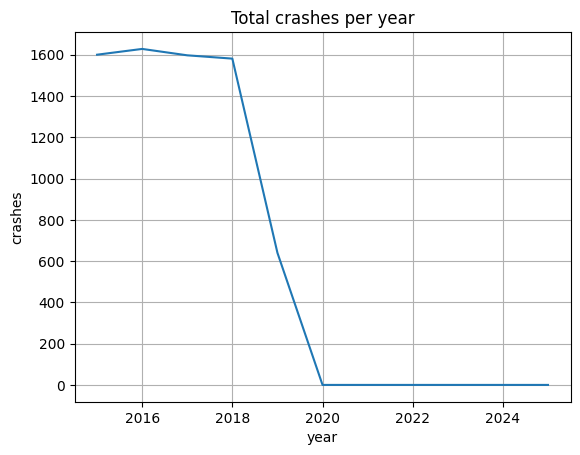

In [33]:
# total no. of crashes reported per  year
ax = sn.lineplot(data=df.groupby('year')[['crashes']].sum().reset_index(), x='year', y='crashes')
ax.set_xticklabels([int(tick) for tick in ax.get_xticks()])
plt.title('Total crashes per year')
plt.grid(True)
plt.show()

> downward trend, multiplicative -> fatilities by year
> 
> downward trend, add -> incidents by year
>
> downward trend, add -> crash by year

# seasonal decomposition

## crashes seasonal pattern

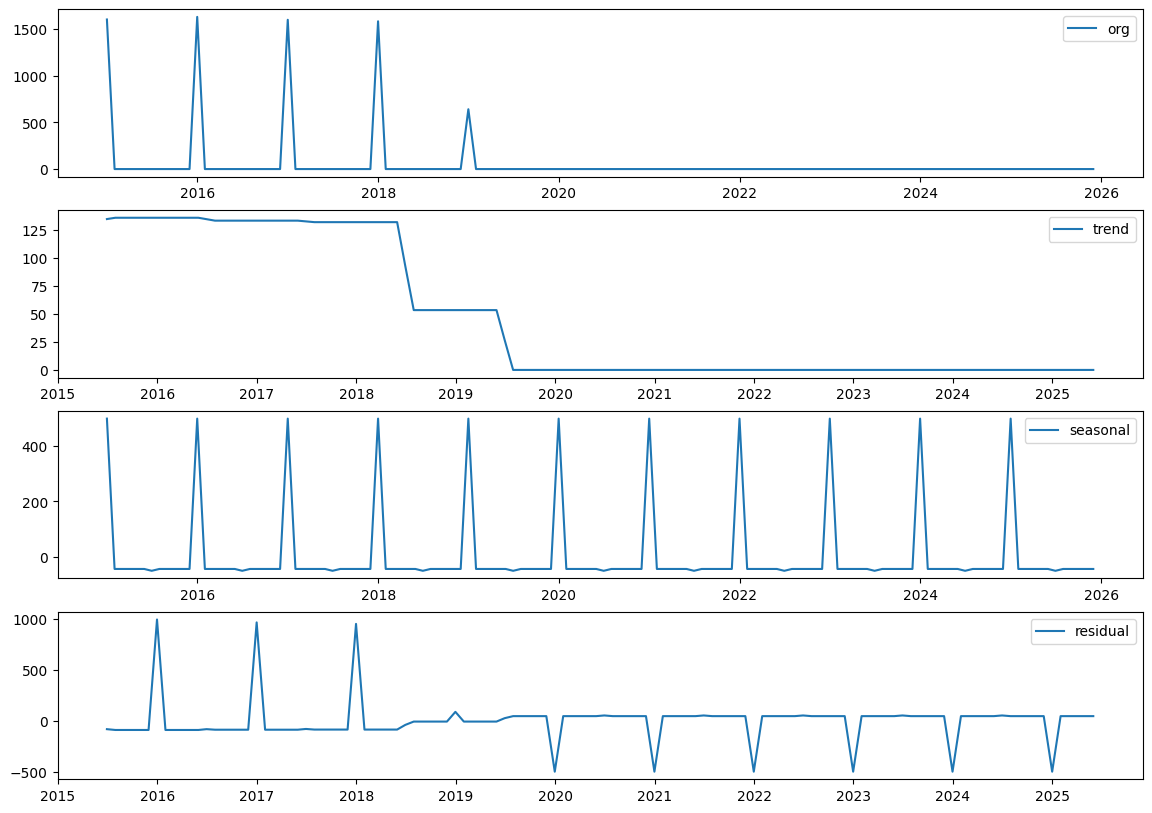

In [34]:
cr_monthly = df['crashes'].resample('M').sum()
dcp_cr = seasonal_decompose(cr_monthly, model='additive', period=12)

add_trend = dcp_cr.trend
add_seasonal = dcp_cr.seasonal
add_resi = dcp_cr.resid

plt.figure(figsize=(14,10))
plt.subplot(411)
plt.plot(dcp_cr.observed, label = 'org')
plt.legend()
plt.subplot(412)
plt.plot(add_trend, label = 'trend')
plt.legend()
plt.subplot(413)
plt.plot(add_seasonal, label = 'seasonal')
plt.legend()
plt.subplot(414)
plt.plot(add_resi, label = 'residual')
plt.legend()
plt.show()

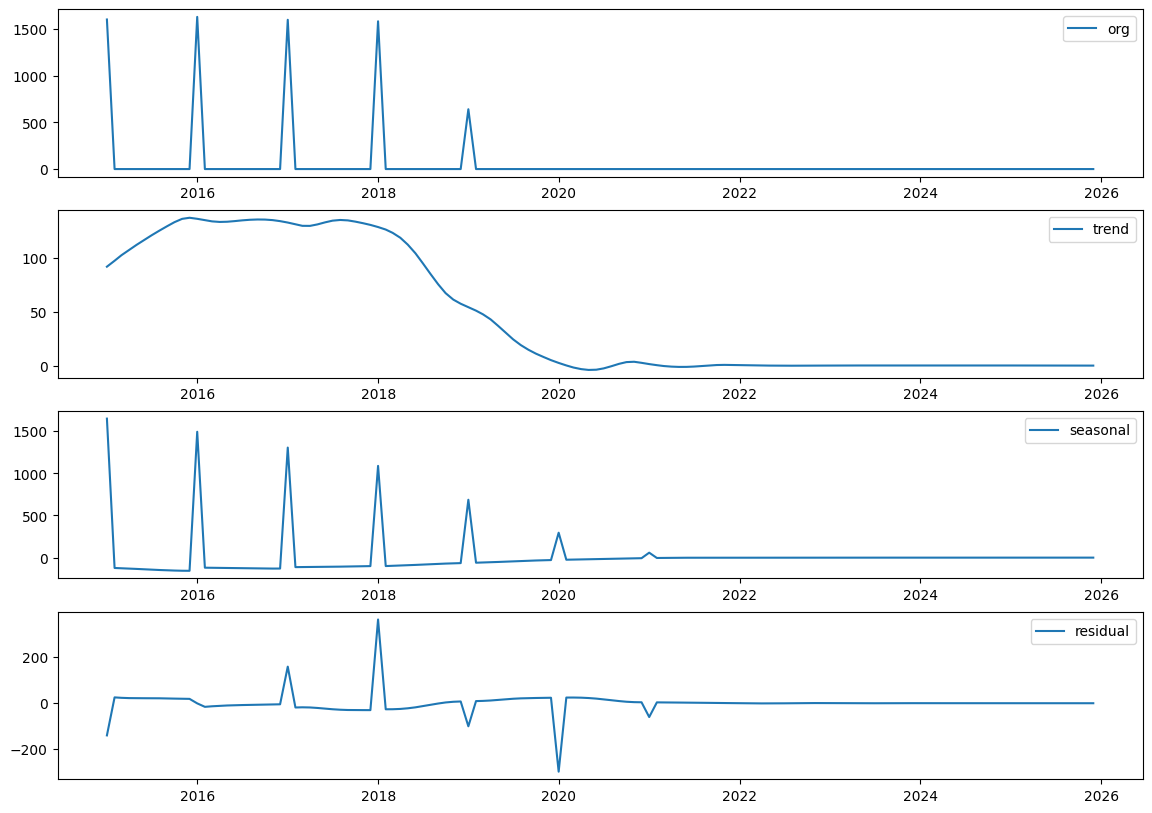

In [35]:
# stl decompostion
stl_cr = STL(cr_monthly, period=12)
res= stl_cr.fit()

plt.figure(figsize=(14,10))
plt.subplot(411)
plt.plot(res.observed, label = 'org')
plt.legend()
plt.subplot(412)
plt.plot(res.trend, label = 'trend')
plt.legend()
plt.subplot(413)
plt.plot(res.seasonal, label = 'seasonal')
plt.legend()
plt.subplot(414)
plt.plot(res.resid, label = 'residual')
plt.legend()
plt.show()

## incidents seasonal pattern

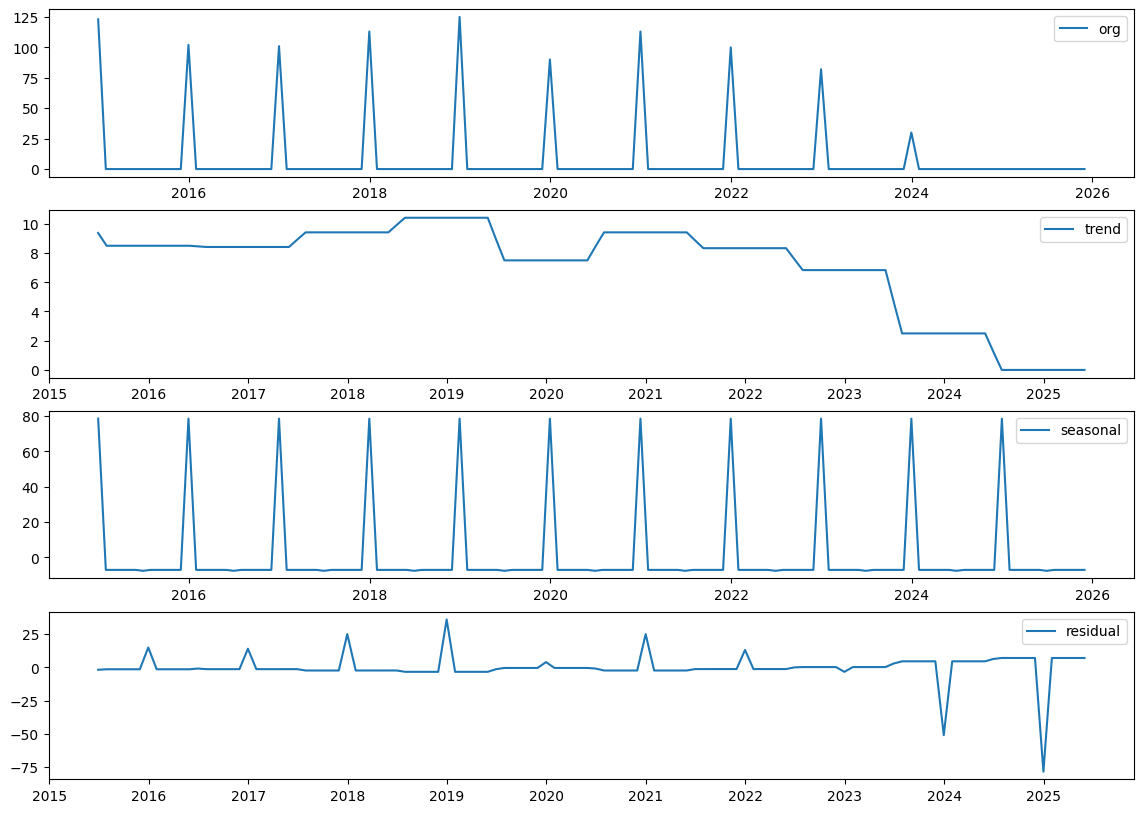

In [36]:
inc_monthly = df['incidents'].resample('M').sum()
dcp_inc = seasonal_decompose(inc_monthly, model='additive', period=12)

add_trend = dcp_inc.trend
add_seasonal = dcp_inc.seasonal
add_resi = dcp_inc.resid

plt.figure(figsize=(14,10))
plt.subplot(411)
plt.plot(dcp_inc.observed, label = 'org')
plt.legend()
plt.subplot(412)
plt.plot(add_trend, label = 'trend')
plt.legend()
plt.subplot(413)
plt.plot(add_seasonal, label = 'seasonal')
plt.legend()
plt.subplot(414)
plt.plot(add_resi, label = 'residual')
plt.legend()
plt.show()

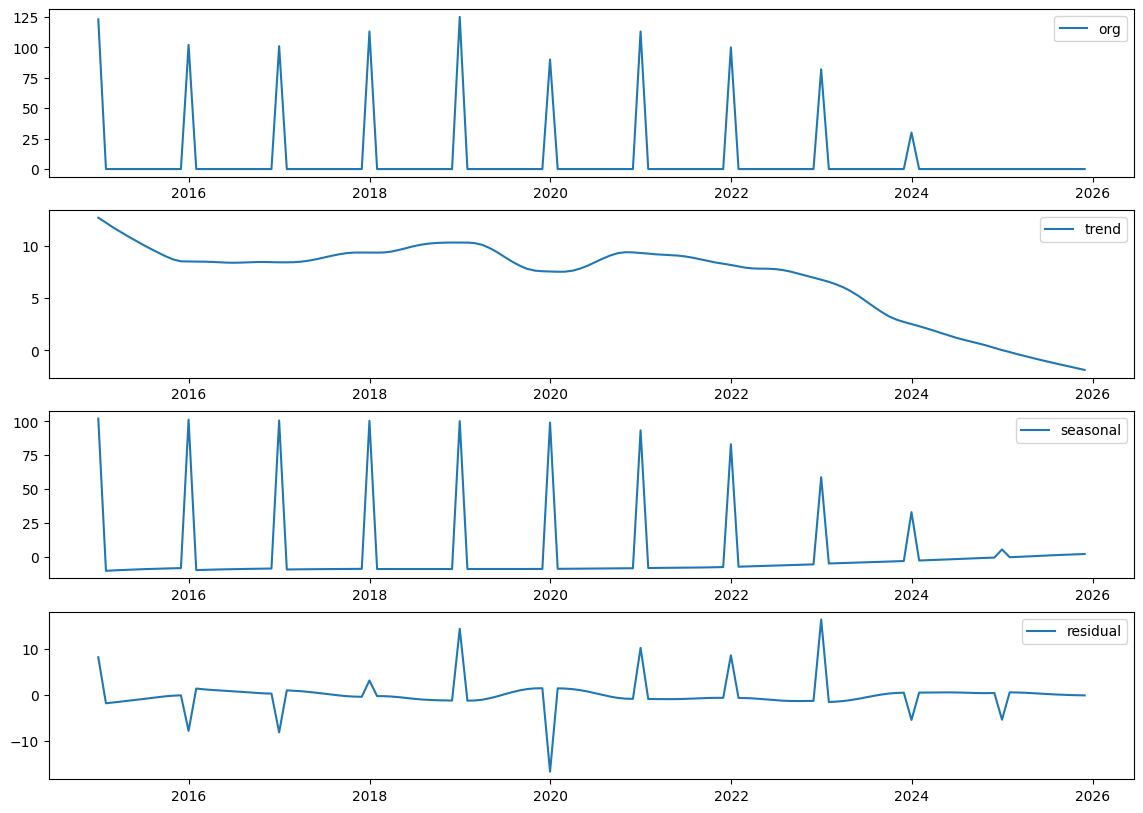

In [37]:
# stl decompostion
stl_inc = STL(inc_monthly, period=12)
res= stl_inc.fit()

plt.figure(figsize=(14,10))
plt.subplot(411)
plt.plot(res.observed, label = 'org')
plt.legend()
plt.subplot(412)
plt.plot(res.trend, label = 'trend')
plt.legend()
plt.subplot(413)
plt.plot(res.seasonal, label = 'seasonal')
plt.legend()
plt.subplot(414)
plt.plot(res.resid, label = 'residual')
plt.legend()
plt.show()

## fatalities seasonal pattern

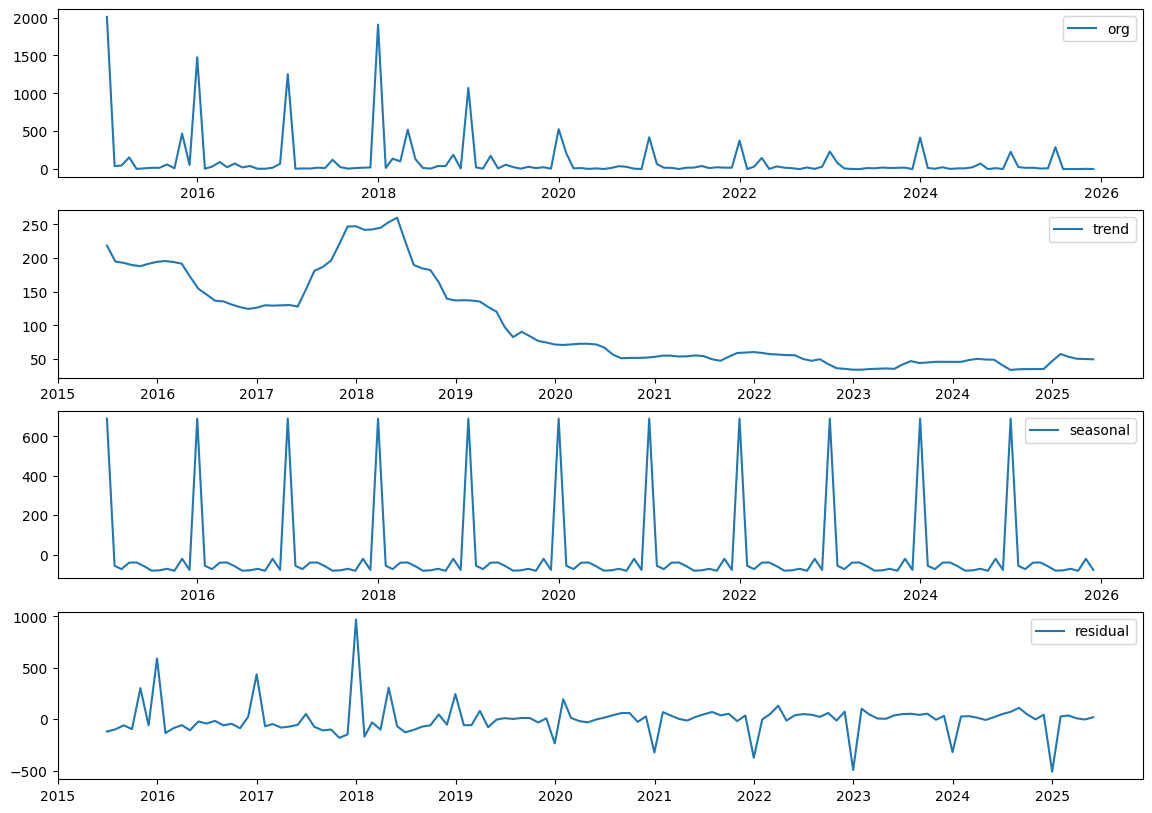

In [38]:
fat_monthly = df['fatalities'].resample('M').sum()
dcp_fat = seasonal_decompose(fat_monthly, model='additive', period=12)

add_trend = dcp_fat.trend
add_seasonal = dcp_fat.seasonal
add_resi = dcp_fat.resid

plt.figure(figsize=(14,10))
plt.subplot(411)
plt.plot(dcp_fat.observed, label = 'org')
plt.legend()
plt.subplot(412)
plt.plot(add_trend, label = 'trend')
plt.legend()
plt.subplot(413)
plt.plot(add_seasonal, label = 'seasonal')
plt.legend()
plt.subplot(414)
plt.plot(add_resi, label = 'residual')
plt.legend()
plt.show()

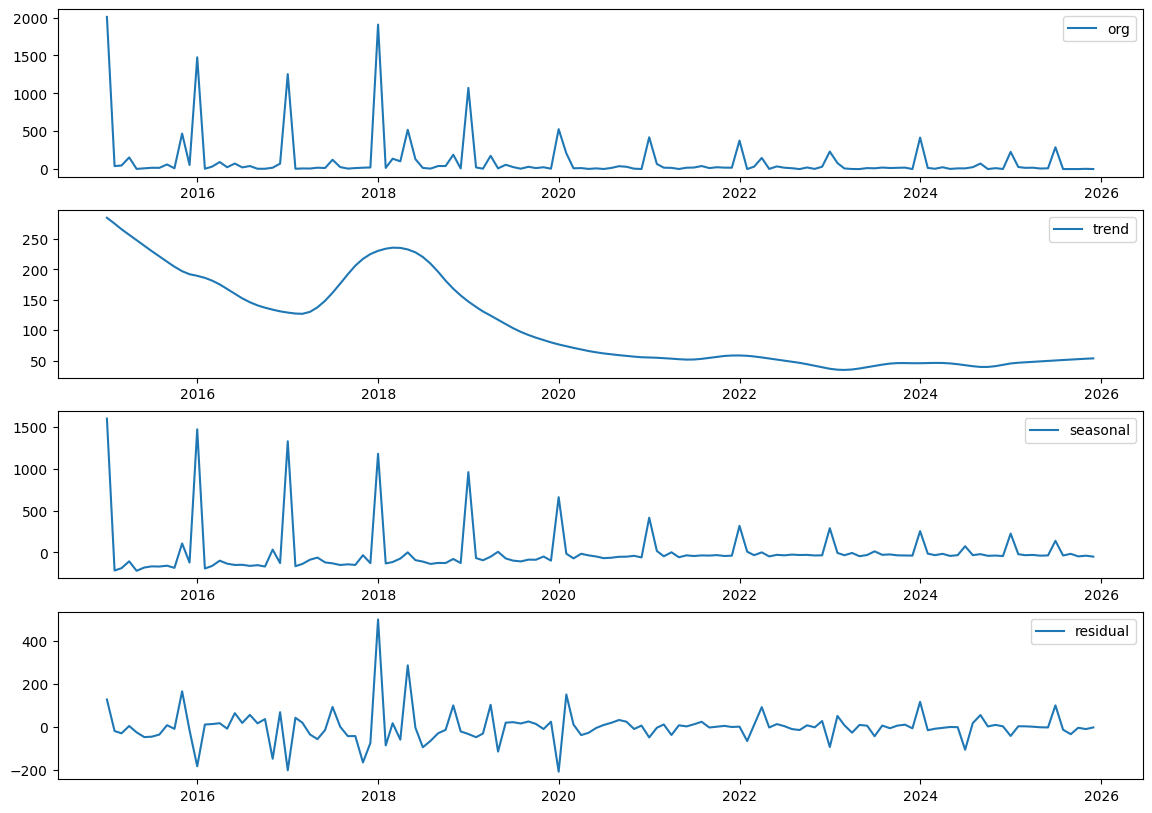

In [39]:
# stl decompostion
fat_monthly1 = df['fatalities'].resample('M').sum()
stl_fat = STL(fat_monthly1, period=12)
res= stl_fat.fit()

plt.figure(figsize=(14,10))
plt.subplot(411)
plt.plot(res.observed, label = 'org')
plt.legend()
plt.subplot(412)
plt.plot(res.trend, label = 'trend')
plt.legend()
plt.subplot(413)
plt.plot(res.seasonal, label = 'seasonal')
plt.legend()
plt.subplot(414)
plt.plot(res.resid, label = 'residual')
plt.legend()
plt.show()

# min-max points per metrics

In [40]:
# df[(df.index=='2025-10-16') | (df.index=='2025-11-14')]

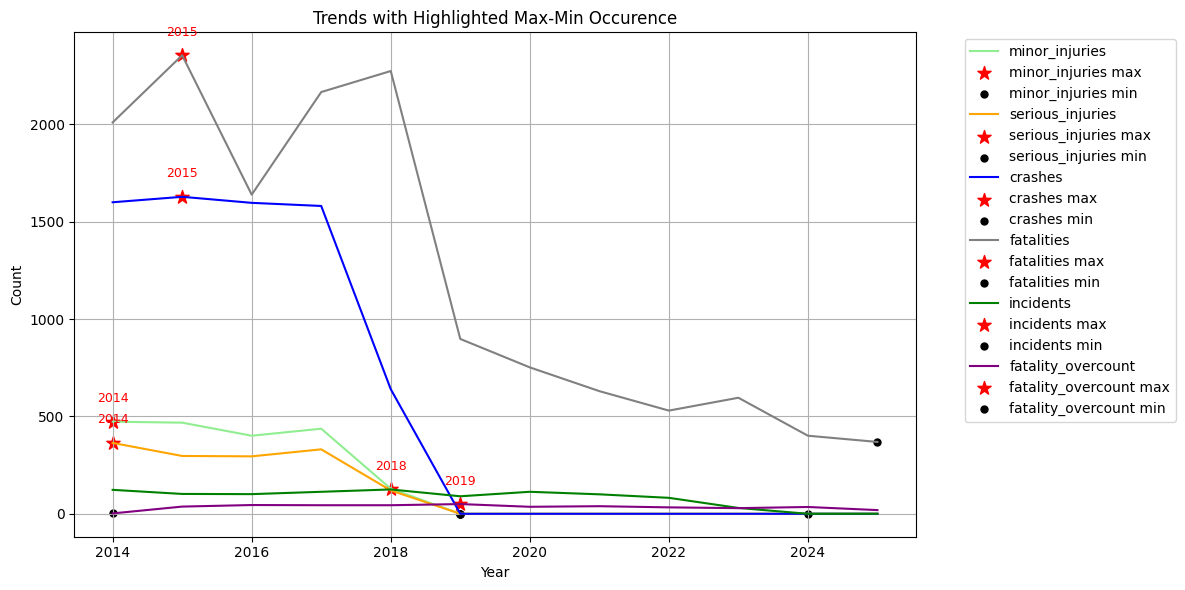

In [41]:
yearly_df = df.resample('Y').sum()[['minor_injuries','serious_injuries','crashes','fatalities','incidents','fatality_overcount']]
yearly_df.index = yearly_df.index.year

plt.figure(figsize=(12,6))
colors = {
    'minor_injuries': 'lightgreen',
    'serious_injuries': 'orange',
    'crashes': 'blue',
    'fatalities': 'grey',
    'incidents': 'green',
    'fatality_overcount': 'purple'
}

for col in yearly_df.columns:
    plt.plot(yearly_df.index, yearly_df[col], label=col, color=colors[col])
    
    max_idx = yearly_df[col].idxmax()
    max_val = yearly_df.loc[max_idx, col]
    plt.scatter(max_idx, yearly_df.loc[max_idx, col], color='red', s=100, marker='*', label=f'{col} max')
    plt.text(max_idx, max_val + 100, str(max_idx), color='red', fontsize=9, ha='center')  # Add year above"
    
    min_idx = yearly_df[col].idxmin()
    plt.scatter(min_idx, yearly_df.loc[min_idx, col], color='black', s=100, marker='.', label=f'{col} min')

plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Trends with Highlighted Max-Min Occurence')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

In [42]:
[{x:df[x].nunique()} for x in df.columns]

[{'aircraft_type': 834},
 {'registration': 2408},
 {'operator': 1465},
 {'fatalities': 65},
 {'location': 2032},
 {'damage': 7},
 {'time': 1},
 {'flight_num': 1},
 {'route': 1},
 {'cn/in': 1},
 {'aboard': 1},
 {'ground': 1},
 {'summ1': 1},
 {'summ2': 4},
 {'crashes': 6},
 {'serious_injuries': 6},
 {'minor_injuries': 6},
 {'incidents': 10},
 {'date': 1742},
 {'year': 11},
 {'month': 12},
 {'day': 31},
 {'hour': 1},
 {'fatality_overcount': 2}]

In [43]:
df['flight_num'].head()

ts
2014-12-31 23:00:00    unknown
2014-12-31 23:00:00    unknown
2015-01-01 23:00:00    unknown
2015-01-02 23:00:00    unknown
2015-01-03 23:00:00    unknown
Name: flight_num, dtype: object

In [44]:
df[df.aircraft_type.str.contains('unknown', case=False)].value_counts().sum()

16